In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

## 1. The Question
Phương pháp xử lý missing values nào (Simple Univariate Imputation vs. Multivariate Iterative Imputation) là tối ưu nhất để bảo toàn cấu trúc phân phối thống kê của các đặc trưng có tỷ lệ missing values cao trong dữ liệu (`budget` và `metascore`) ? 

## 2. What are the benefits of finding the answer?
- **Data Integrity**: Đảm bảo rằng việc điền dữ liệu thiếu không làm biến dạng bản chất của dữ liệu gốc.
- **Model Performance**: `budget` và `metascore` có thể xem là hai trong số các đặc trưng quan trọng nhất để dự đoán `rating`. Nếu phương pháp xử lý làm mất đi sự biến thiên (variance) tự nhiên, các mô hình học máy khi áp dụng vào sẽ học sai quy luật, dẫn đến giảm độ chính xác.
- **Bias Mitigation**: Tránh hiện tượng ép dữ liệu về giá trị trung tâm (Mean/Median), vốn thường làm giảm độ lệch chuẩn và gây ra các kết luận sai lầm về mối tương quan giữa kinh phí và chất lượng phim.

## 3. How to find the answer by using data?
Nhóm thực hiện các bước thực nghiệm sau:
- **Baseline**: Lấy phân phối của dữ liệu gốc (sau khi đã loại bỏ các dòng NaN) làm chuẩn.
- **Simple Imputation (Median)**: Điền các giá trị thiếu bằng trung vị của chính cột đó.
- **Iterative Imputation (MICE)**: Sử dụng thuật toán IterativeImputer (dựa trên Random Forest) để dự đoán giá trị thiếu của `budget` dựa trên dữ liệu của các biến còn lại. 
- **Comparison**: So sánh KDE (Kernel Density Estimate) và các chỉ số thống kê (Mean, Std, Skewness) giữa các phương pháp.

Đầu tiên là bước chuẩn bị dữ liệu qua việc load dữ liệu đã được làm sạch từ trước. 

In [2]:
# Xác định đường dẫn file
path = '../data/cleaned/IMDB_movies.csv'

# Load dữ liệu từ CSV
df = pd.read_csv(path)

Trước khi áp dụng Iterative Imputer, vì dữ liệu có 2 đặc trưng `mpa` và `genres` còn đang là kiểu categorical, vậy nên dữ liệu của 2 cột này sẽ được chuyển sang dạng số bằng phương pháp Label Encoding.

In [3]:
df['mpa'] = df['mpa'].fillna('Unrated')

genres_mode = df['genres'].mode()[0] 
df['genres'] = df['genres'].fillna(genres_mode)

# Trích xuất primary_genres 
df['primary_genres'] = df['genres'].apply(lambda x: x.split(',')[0].strip())

# Khởi tạo Label Encoder
le_mpa = LabelEncoder()
le_genre = LabelEncoder()

df['mpa_encoded'] = le_mpa.fit_transform(df['mpa'])
df['genres_encoded'] = le_genre.fit_transform(df['primary_genres'])

Lấy các cột dữ liệu mục tiêu để so sánh là `budget`, `metascore` và các đặc trung khác dùng cho phương pháp MICE là `budget`, `metascore`, `release_year`, `vote_count`, `run_time`, `genres_encoded`, `mpa_encoded`.

In [4]:
cols_to_compare = ['budget', 'metascore']

features_to_use = ['budget', 'metascore', 'release_year', 'vote_count', 'run_time', 'genres_encoded', 'mpa_encoded']

Tiến hành cấu hình Simple Imputation (dùng Median để điền khuyết) và Iterative Imputation (dùng thuật toán Random Forest để dựa trên dữ liệu của các biến `budget`, `metascore`, `release_year`, `vote_count`, `run_time`, `genres_encoded`, `mpa_encoded` để điền các giá trị thiếu). Sau đó thực hiện điền vào các dữ liệu thiếu trên 2 phương pháp vừa cấu hình. 

In [5]:
# Simple Imputation
median_imputer = SimpleImputer(strategy='median')

data_simple = pd.DataFrame(
    median_imputer.fit_transform(df[cols_to_compare]), 
    columns=cols_to_compare
)

# Iterative Imputation
iter_imputer = IterativeImputer(
    estimator=RandomForestRegressor(n_estimators=10, random_state=42),
    max_iter=10,
    random_state=42,
    min_value=0 
)

data_iter_imputed_array = iter_imputer.fit_transform(df[features_to_use])

data_iter_full = pd.DataFrame(data_iter_imputed_array, columns=features_to_use)

data_mice = data_iter_full[cols_to_compare]

/home/duyhoang/anaconda3/lib/python3.13/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


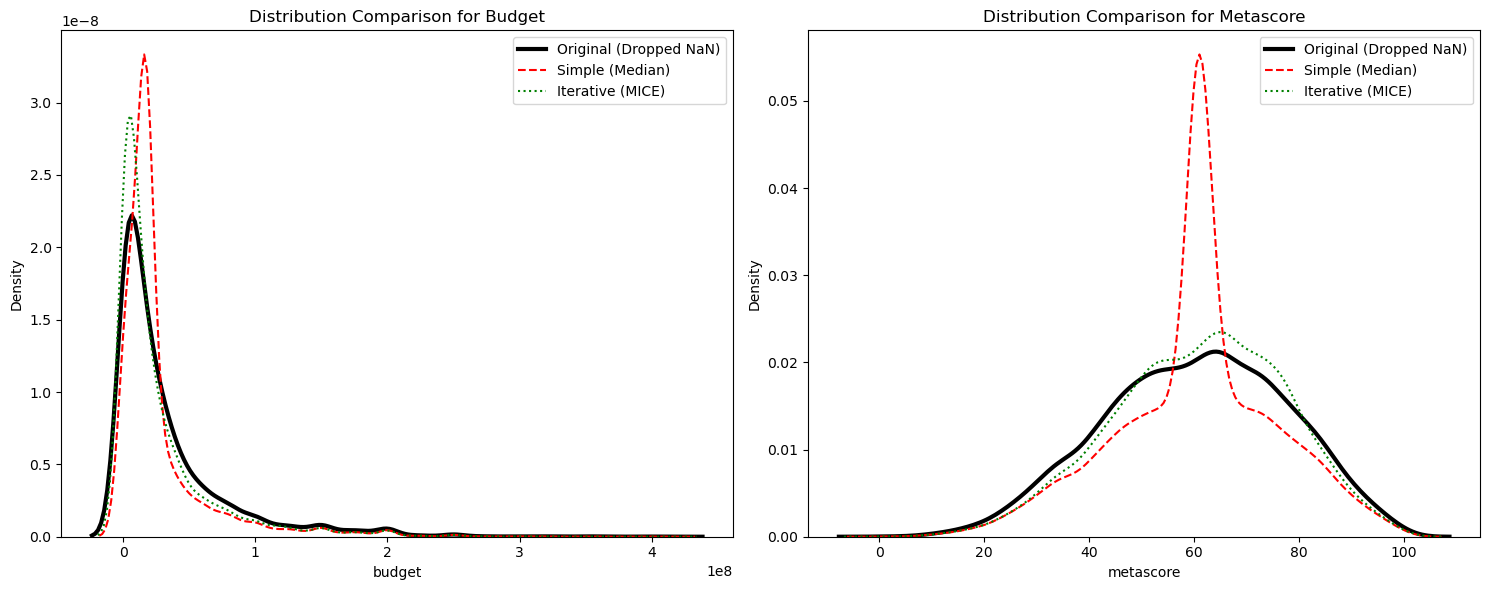

In [6]:
# Visualiztion 
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

for i, col in enumerate(cols_to_compare):
    # Vẽ dữ liệu gốc 
    sns.kdeplot(df[col].dropna(), label='Original (Dropped NaN)', color='black', lw=3, ax=axes[i])
    
    # Vẽ dữ liệu Simple Imputation
    sns.kdeplot(data_simple[col], label='Simple (Median)', ls='--', color='red', ax=axes[i])
    
    # Vẽ dữ liệu MICE
    sns.kdeplot(data_mice[col], label='Iterative (MICE)', ls=':', color='green', ax=axes[i])
    
    axes[i].set_title(f'Distribution Comparison for {col.capitalize()}')
    axes[i].set_xlabel(col)
    axes[i].legend()

plt.tight_layout()
plt.show()

In [7]:
# Thống kê mô tả 
print("Comparison of Standard Deviation (Std):")

# Tạo DataFrame so sánh độ lệch chuẩn
stats = pd.DataFrame({
    'Original': df[cols_to_compare].std(),     
    'Simple (Median)': data_simple.std(),
    'Iterative (MICE)': data_mice.std()
})

print(stats)

# Tính thêm % thay đổi so với gốc để thấy rõ mức độ sụt giảm phương sai
print("\nPercentage of Std retained vs Original:")
print((stats.div(stats['Original'], axis=0) * 100).round(2))

Comparison of Standard Deviation (Std):
               Original  Simple (Median)  Iterative (MICE)
budget     4.576452e+07     3.805135e+07      4.026256e+07
metascore  1.743844e+01     1.520713e+01      1.640030e+01

Percentage of Std retained vs Original:
           Original  Simple (Median)  Iterative (MICE)
budget        100.0            83.15             87.98
metascore     100.0            87.20             94.05
